<a href="https://colab.research.google.com/github/Aditya-Gupta-ctrl/MRI-detector/blob/main/mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])
    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

In [ ]:
tr_df = train_df('/content/drive/MyDrive/archive/Training')

In [ ]:
tr_df

,Class Path,Class
0,/content/drive/MyDrive/archive/Training/pituit...,pituitary
1,/content/drive/MyDrive/archive/Training/pituit...,pituitary
2,/content/drive/MyDrive/archive/Training/pituit...,pituitary
3,/content/drive/MyDrive/archive/Training/pituit...,pituitary
4,/content/drive/MyDrive/archive/Training/pituit...,pituitary
...,...,...
5799,/content/drive/MyDrive/archive/Training/mening...,meningioma
5800,/content/drive/MyDrive/archive/Training/mening...,meningioma
5801,/content/drive/MyDrive/archive/Training/mening...,meningioma
5802,/content/drive/MyDrive/archive/Training/mening...,meningioma


In [ ]:
ts_df = test_df('/content/drive/MyDrive/archive/Testing')

In [ ]:
ts_df

,Class Path,Class
0,/content/drive/MyDrive/archive/Testing/pituita...,pituitary
1,/content/drive/MyDrive/archive/Testing/pituita...,pituitary
2,/content/drive/MyDrive/archive/Testing/pituita...,pituitary
3,/content/drive/MyDrive/archive/Testing/pituita...,pituitary
4,/content/drive/MyDrive/archive/Testing/pituita...,pituitary
...,...,...
1306,/content/drive/MyDrive/archive/Testing/glioma/...,glioma
1307,/content/drive/MyDrive/archive/Testing/glioma/...,glioma
1308,/content/drive/MyDrive/archive/Testing/glioma/...,glioma
1309,/content/drive/MyDrive/archive/Testing/glioma/...,glioma


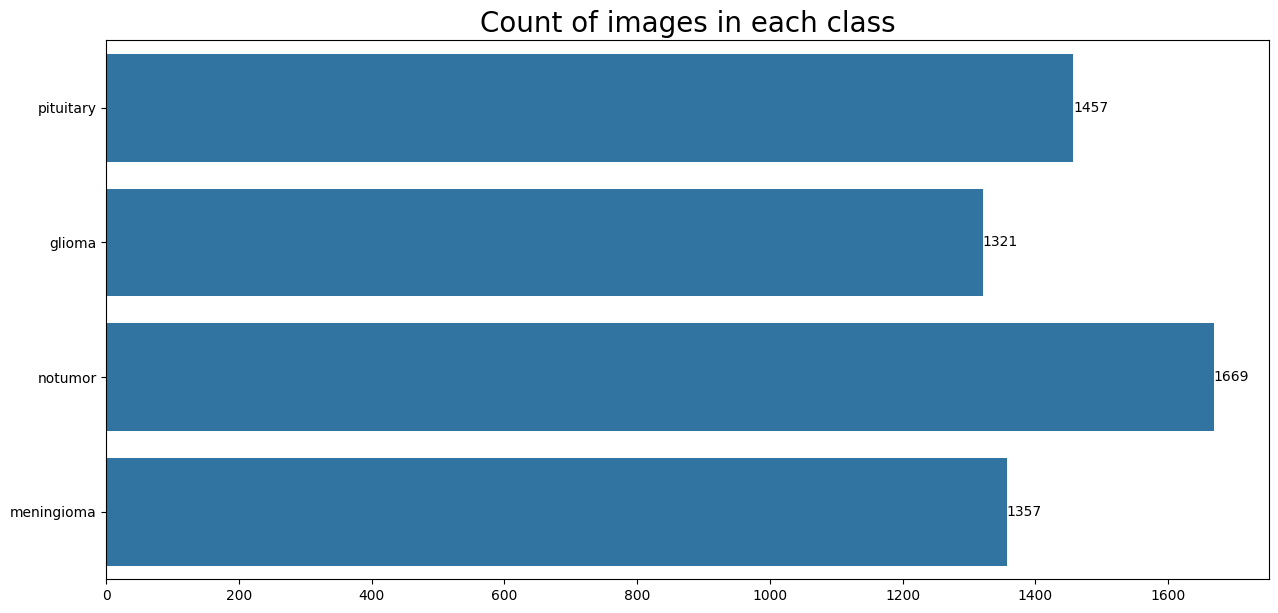

In [ ]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

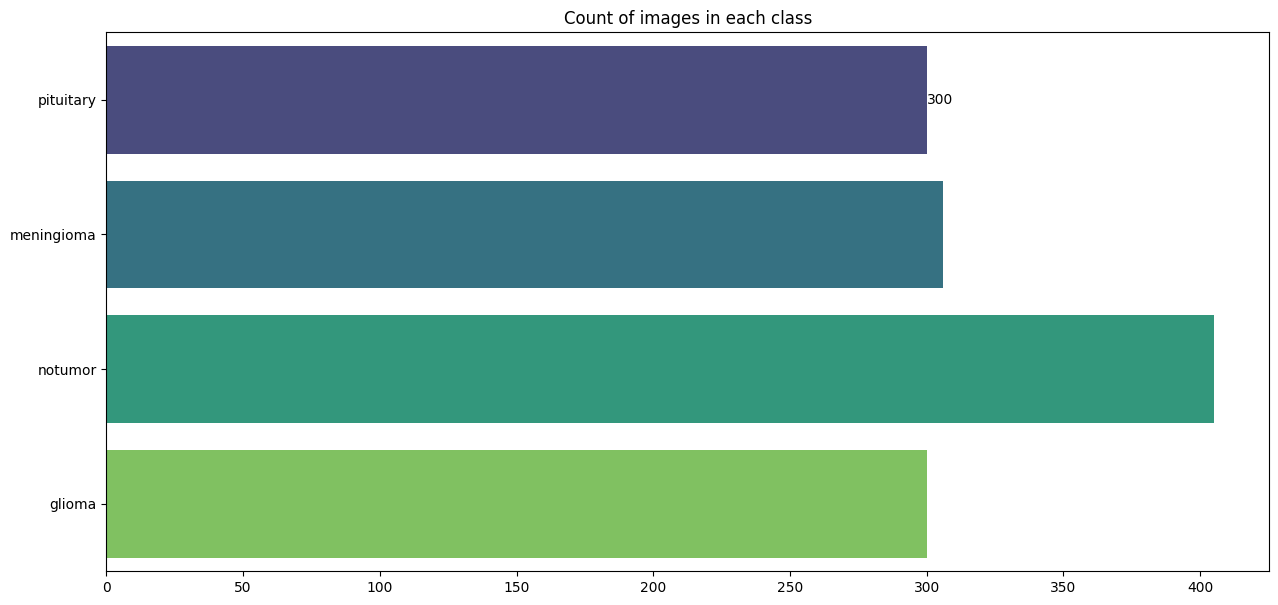

In [ ]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

 **2.2 Split data into train, test, valid**

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [ ]:
valid_df

,Class Path,Class
1297,/content/drive/MyDrive/archive/Testing/glioma/...,glioma
318,/content/drive/MyDrive/archive/Testing/meningi...,meningioma
61,/content/drive/MyDrive/archive/Testing/pituita...,pituitary
373,/content/drive/MyDrive/archive/Testing/meningi...,meningioma
1120,/content/drive/MyDrive/archive/Testing/glioma/...,glioma
...,...,...
1070,/content/drive/MyDrive/archive/Testing/glioma/...,glioma
860,/content/drive/MyDrive/archive/Testing/notumor...,notumor
1284,/content/drive/MyDrive/archive/Testing/glioma/...,glioma
494,/content/drive/MyDrive/archive/Testing/meningi...,meningioma


In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5804 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


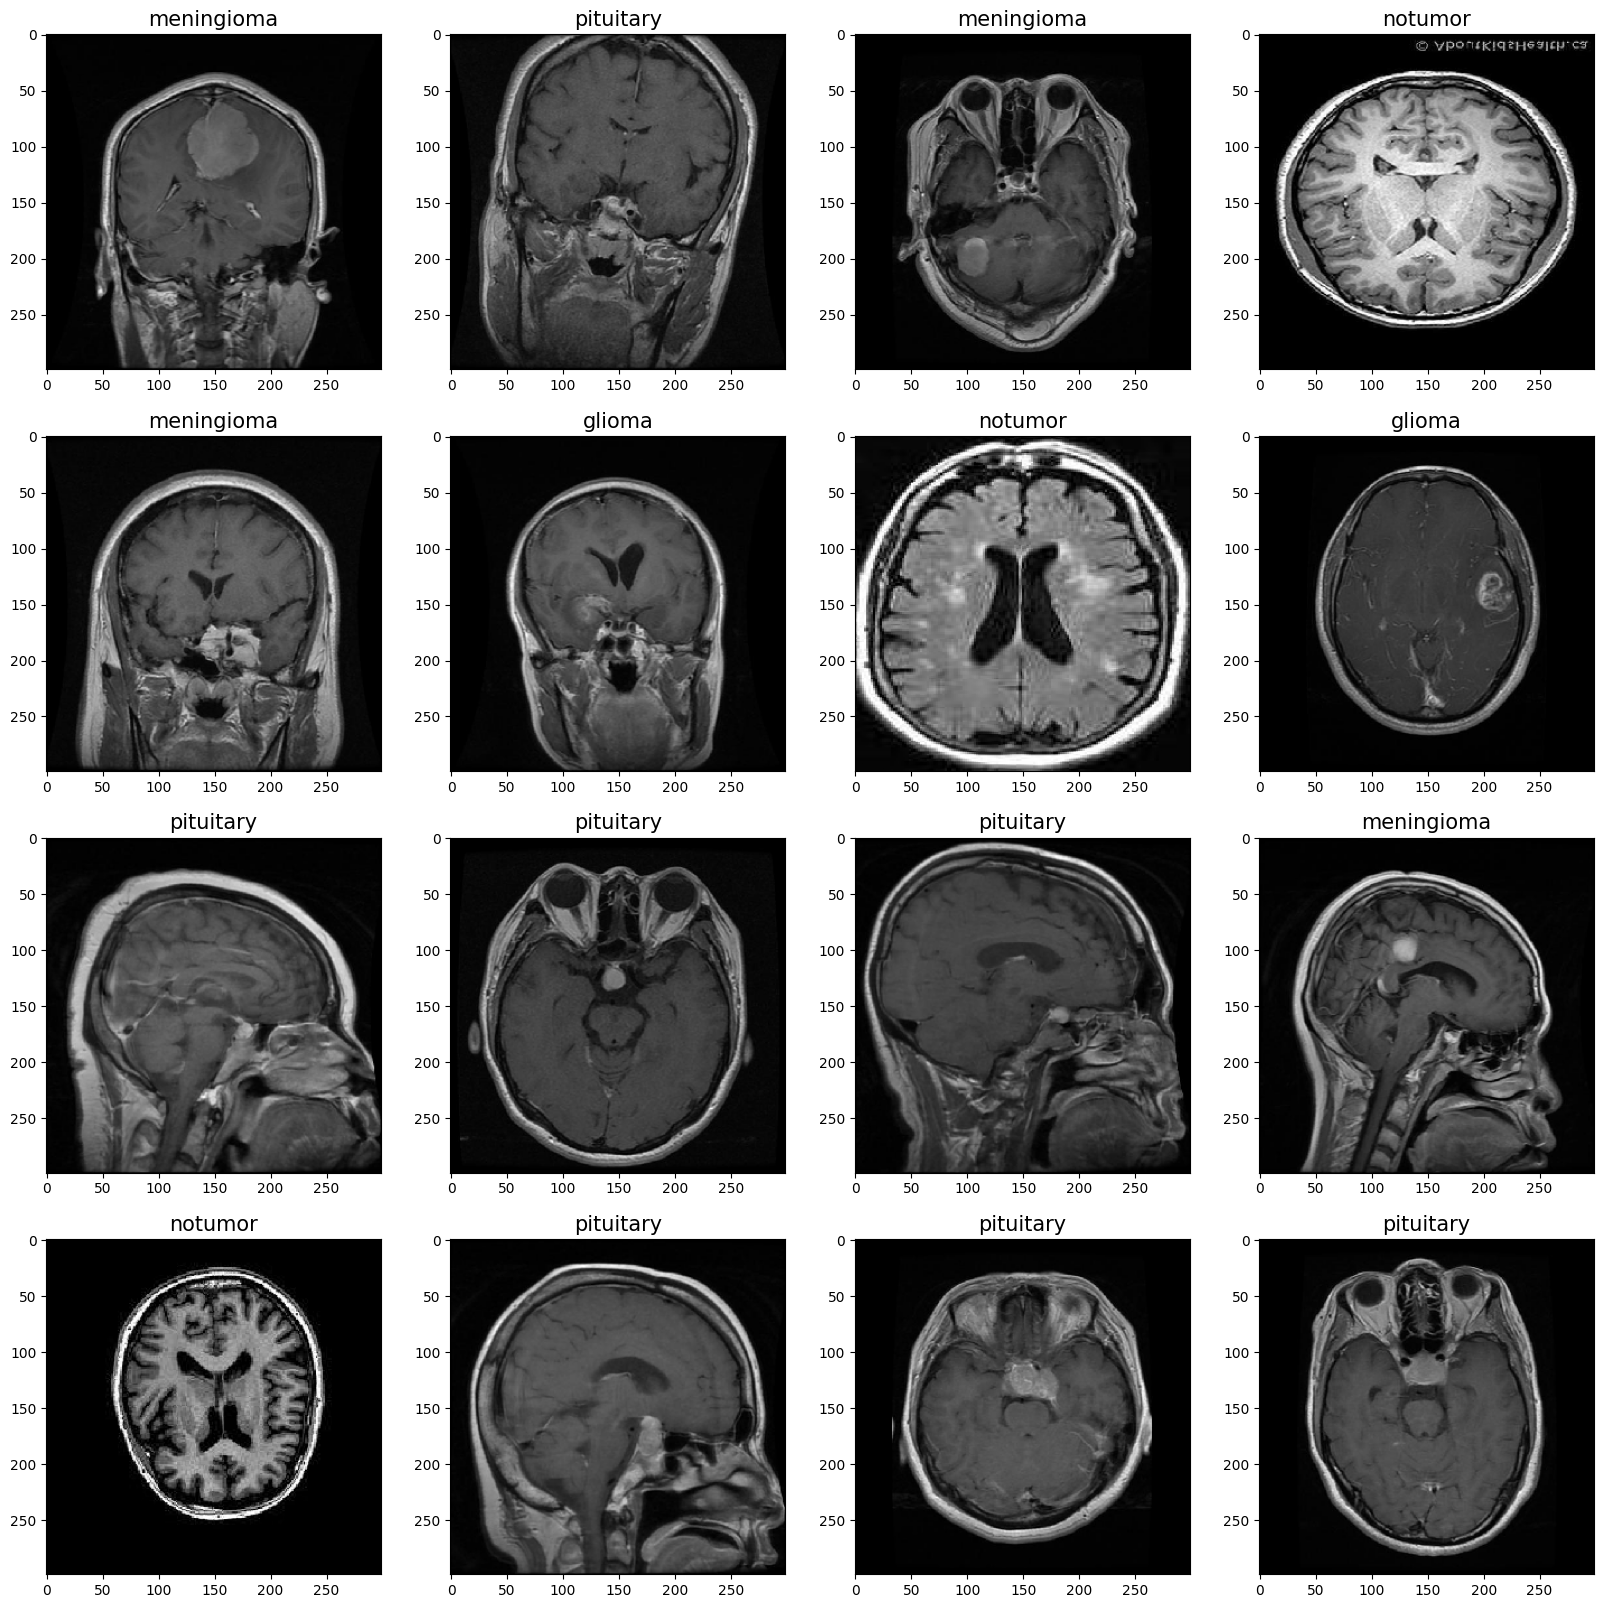

In [17]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()


In [19]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    Input(shape=img_shape), # Add an Input layer to define the input shape
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

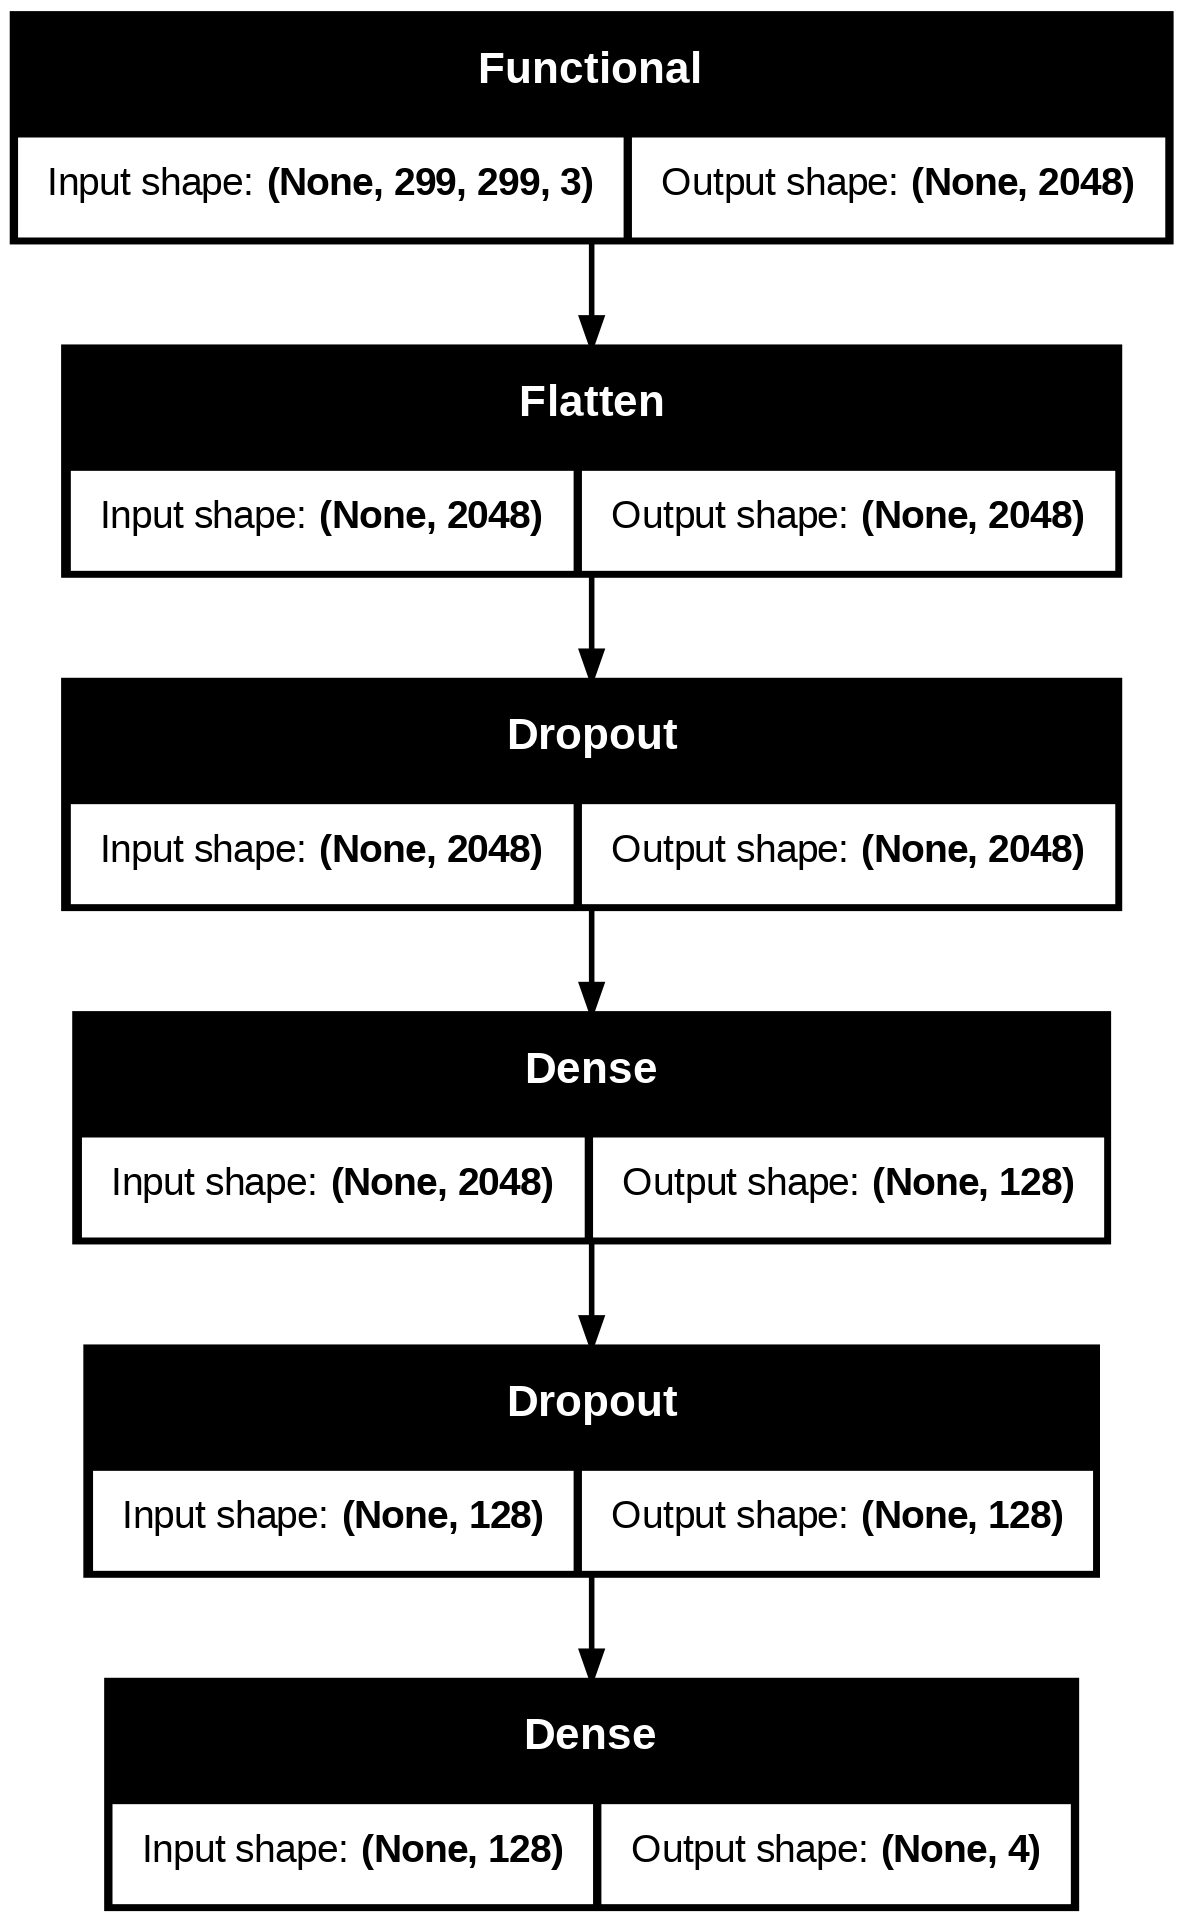

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 4246s 23s/step - accuracy: 0.7060 - loss: 0.8110 - precision: 0.8029 - recall: 0.5760 - val_accuracy: 0.9298 - val_loss: 0.1965 - val_precision: 0.9395 - val_recall: 0.9252
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 139s 761ms/step - accuracy: 0.9708 - loss: 0.0966 - precision: 0.9716 - recall: 0.9682 - val_accuracy: 0.8733 - val_loss: 0.3034 - val_precision: 0.8733 - val_recall: 0.8733
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 138s 760ms/step - accuracy: 0.9916 - loss: 0.0315 - precision: 0.9916 - recall: 0.9907 - val_accuracy: 0.9618 - val_loss: 0.1061 - val_precision: 0.9632 - val_recall: 0.9603
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 143s 763ms/step - accuracy: 0.9907 - loss: 0.0268 - precision: 0.9907 - recall: 0.9900 - val_accuracy: 0.9588 - val_loss: 0.1529 - val_precision: 0.9602 - val_recall: 0.9588
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 139s 762ms/step - accuracy: 0.9920 - loss: 0.0274 - precision: 0.9921 - recall: 0.9914 - val_accuracy: 0.

In [22]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

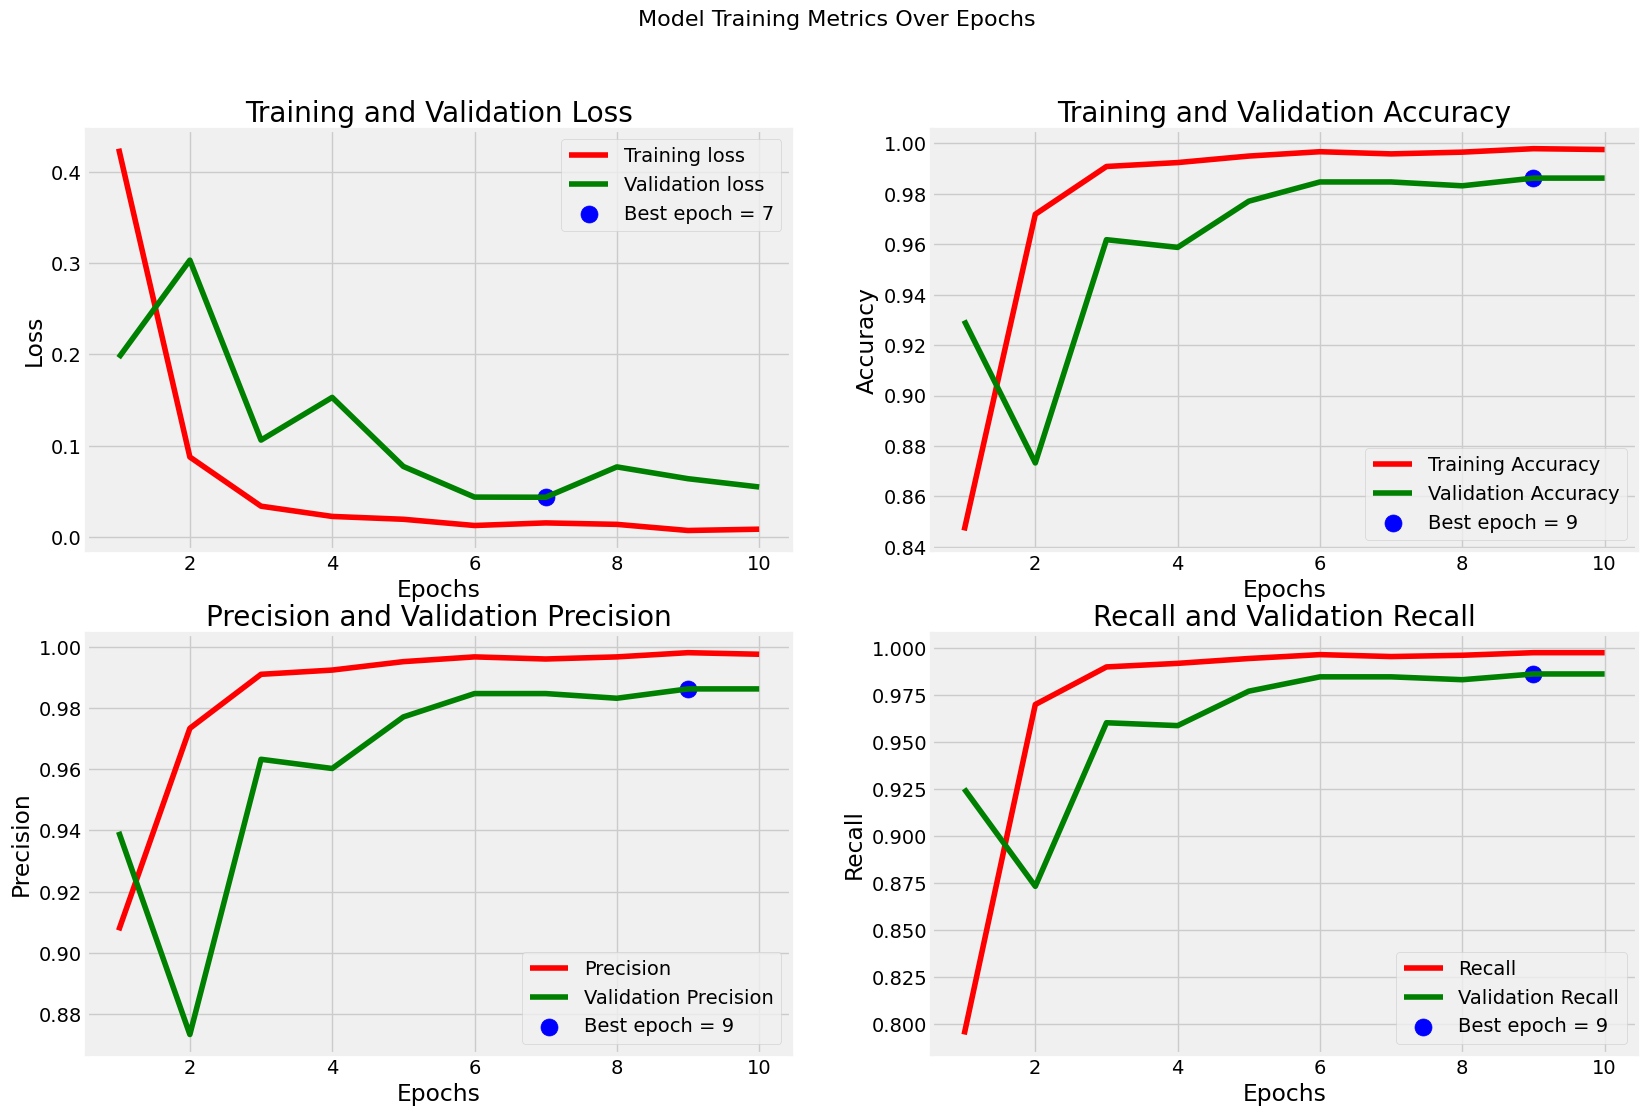

In [23]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [24]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

182/182 ━━━━━━━━━━━━━━━━━━━━ 59s 322ms/step - accuracy: 0.9997 - loss: 5.3905e-04 - precision: 0.9997 - recall: 0.9997
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.9892 - loss: 0.0582 - precision: 0.9892 - recall: 0.9892
41/41 ━━━━━━━━━━━━━━━━━━━━ 331s 8s/step - accuracy: 0.9966 - loss: 0.0233 - precision: 0.9966 - recall: 0.9966
Train Loss: 0.0007
Train Accuracy: 99.97%
--------------------
Validation Loss: 0.0712
Validation Accuracy: 98.63%
--------------------
Test Loss: 0.0503
Test Accuracy: 99.24%


In [26]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step


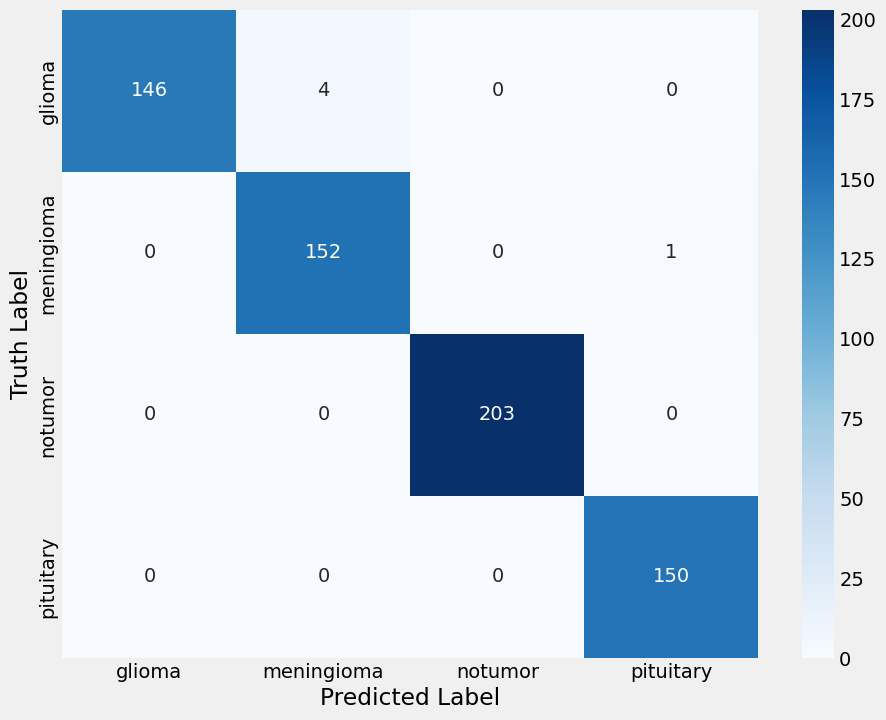

In [27]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [28]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       150
           1       0.97      0.99      0.98       153
           2       1.00      1.00      1.00       203
           3       0.99      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [29]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


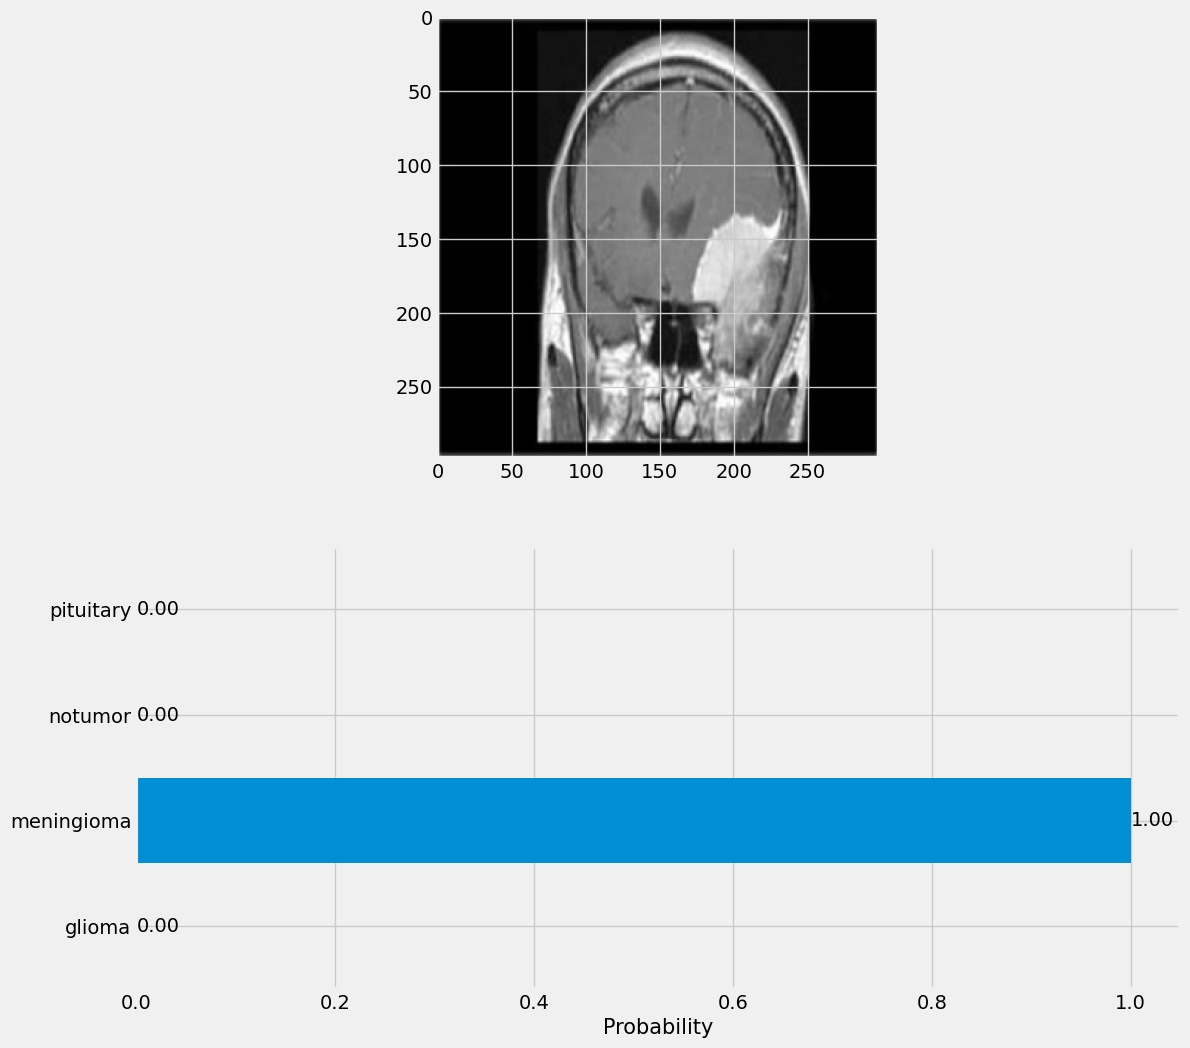

In [30]:
predict('/content/drive/MyDrive/archive/Testing/meningioma/Te-meTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


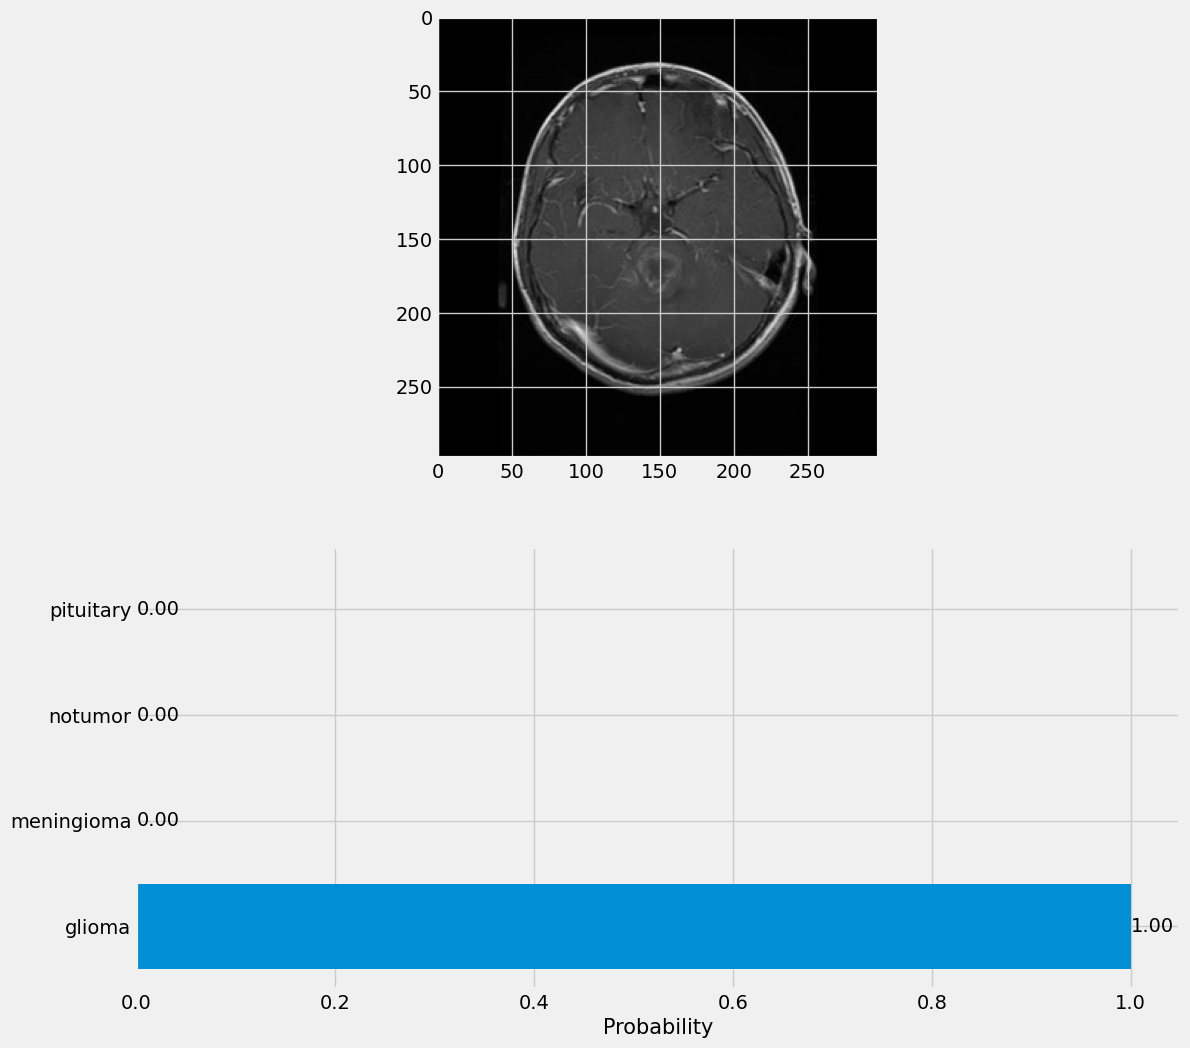

In [31]:
predict('/content/drive/MyDrive/archive/Testing/glioma/Te-glTr_0007.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


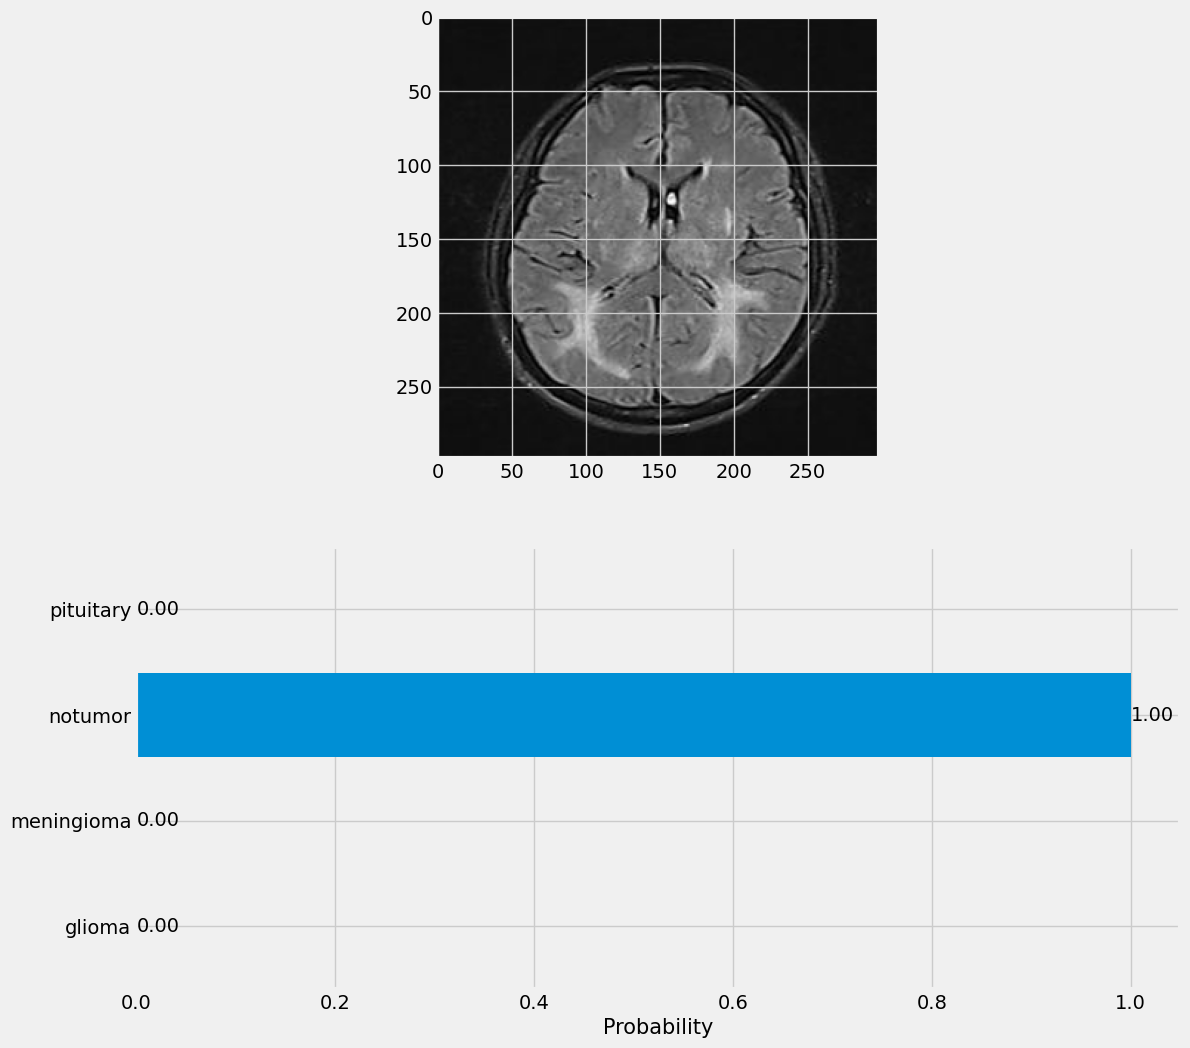

In [32]:
predict('/content/drive/MyDrive/archive/Testing/notumor/Te-noTr_0001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


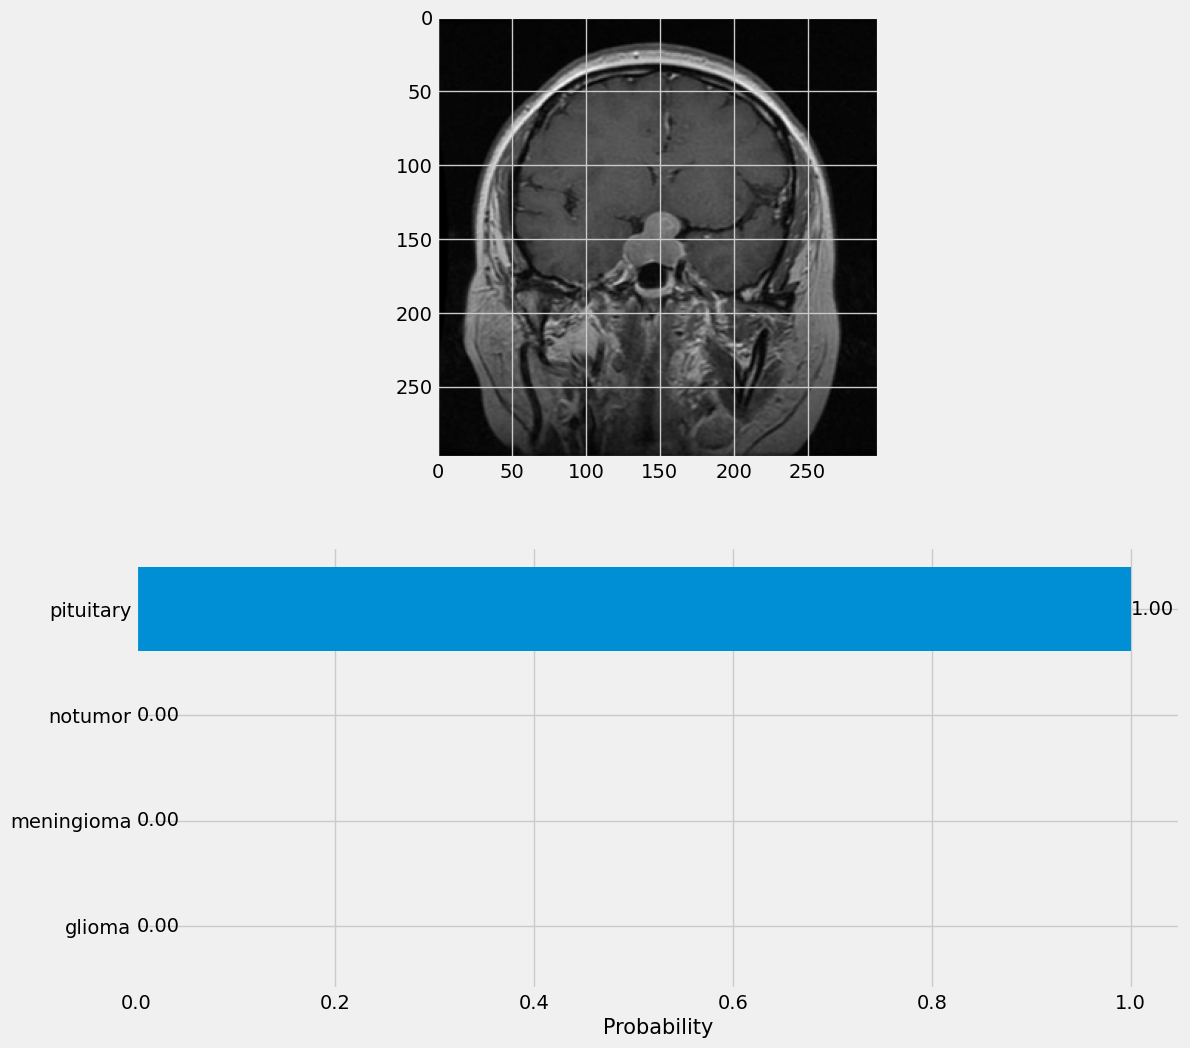

In [33]:
predict('/content/drive/MyDrive/archive/Testing/pituitary/Te-piTr_0001.jpg')